<a href="https://colab.research.google.com/github/ruebot/notebooks/blob/main/yfile_indigenous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```scala
val data = "/mnt/vol1/data_sets/indigenous_framework/yfile/web-pages.csv"

val df = spark.read.option("timestampFormat", "yyyy/MM/dd HH:mm:ss ZZ").format("csv").option("multiline", true).option("escape", "\"").option("encoding", "utf-8").load(data)

val indigenous = df.filter(col("_c2").rlike("yfile")).dropDuplicates("_c2").dropDuplicates("_c6").filter(!col("_c2").rlike("/search/") && !col("_c2").rlike("/tag/") && !col("_c2").rlike("/author/")).filter(col("_c6").ilike("%indigenous%"))

indigenous.coalesce(1).write.option("timestampFormat", "yyyy/MM/dd HH:mm:ss ZZ").format("csv").option("escape", "\"").option("encoding", "utf-8").save("/mnt/vol1/data_sets/indigenous_framework/yfile/indigenous-web-pages")
```

In [1]:
data = "https://ruebot.net/indigenous-web-pages.csv"

In [2]:
import pandas as pd
import altair as alt
from matplotlib import pyplot as plt

### Web Pages

Provides the following columns:

* crawl date
* web domain
* URL
* MIME type as provided by the web server
* MIME type as detected by Apache TIKA
* content (HTTP headers and HTML removed)

In [3]:
web_pages = pd.read_csv(data)

In [4]:
web_pages

,crawl_date,domain,url,mime_type_web_server,mime_type_tika,language,content
0,20210303212147,yorku.ca,https://yfile.news.yorku.ca/2017/06/06/yudisco...,text/html,text/html,en,#YUDiscover photo contest highlights beauty of...
1,20220617202108,yorku.ca,https://yfile.news.yorku.ca/2012/05/08/innovat...,text/html,text/html,en,2007-10_seifert – YFile Skip to content Awards...
2,20210305050546,yorku.ca,https://yfile.news.yorku.ca/2013/03/28/hold-20...,text/html,text/html,en,2012 Salary Disclosure Report now available – ...
3,20200302125905,yorku.ca,https://yfile.news.yorku.ca/2016/09/28/2016-me...,text/html,text/html,en,2016 Media Architecture Summit focuses on art ...
4,20200816001414,yorku.ca,https://yfile.news.yorku.ca/2018/03/28/2017-sa...,text/html,text/html,en,2017 Salary Disclosure Report now available – ...
...,...,...,...,...,...,...,...
18612,20200302023031,yorku.ca,https://yfile.news.yorku.ca/2018/06/06/young-r...,text/html,text/html,en,Young researchers in exo-planetary science gai...
18613,20210320123621,yorku.ca,https://yfile.news.yorku.ca/2016/03/16/youre-i...,text/html,text/html,en,You’re Invited: A Special Red & White Day #YUT...
18614,20211116004831,yorku.ca,https://yfile.news.yorku.ca/2021/11/02/mclaugh...,text/html,text/html,en,image-2 – YFile Skip to content Awards & Recog...
18615,20210305052757,yorku.ca,https://yfile.news.yorku.ca/2013/05/28/elite-t...,text/html,text/html,en,‘Elite to elitist’: How the Abercrombie & Fitc...


In [5]:
web_pages.shape[0]

18617

## Text Analysis

Next, we'll do some basic text analysis with our `web_pages` DataFrame with `nltk` and`spaCy`, and end with a word cloud.


In [6]:
import re

import nltk

In [7]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

We need to set the [`mode.chained_assignment`](https://pandas.pydata.org/docs/user_guide/options.html?highlight=chained_assignment) to `None` now to silence some exception errors that will come up.

In [10]:
pd.options.mode.chained_assignment = None

Next, we'll setup a tokenizer which will split on words, and create a new column which is the tokenized text.

In [11]:
tokenizer = nltk.RegexpTokenizer(r"\w+")

In [12]:
web_pages["content_tokenized"] = web_pages["content"].map(tokenizer.tokenize)

Now well create a column with the tokenized value count.

In [13]:
web_pages["content_tokens"] = web_pages["content_tokenized"].apply(lambda x: len(x))

### Basic word count statistics with pandas!

Now we can use the power of pandas [Statisitcal functions](https://pandas.pydata.org/docs/user_guide/computation.html) to show us some basic statistics about the tokens.

**Mean**

In [14]:
web_pages["content_tokens"].mean()

694.9365096417253

**Standard deviation**


In [15]:
web_pages["content_tokens"].std()

349.83593405486187

**Max**

In [16]:
web_pages["content_tokens"].max()

6596

**Min**

In [17]:
web_pages["content_tokens"].min()

53

### Pages with most words

Let's create a bar chart that shows the pages with the most words. Here we can see the power of pandas at work, in terms of both analysis and visualization.

First, let's show the query to get the data for our chart.

In [18]:
word_count = (
    web_pages[["url", "content_tokens"]]
    .sort_values(by="content_tokens", ascending=False)
    .head(25)
)

In [19]:
word_count

,url,content_tokens
13899,https://yfile.news.yorku.ca/2020/09/24/faculty...,6596
927,https://yfile.news.yorku.ca/2019/09/12/signifi...,6332
13034,http://yfile.news.yorku.ca/2019/09/12/signific...,6329
8504,https://yfile.news.yorku.ca/2019/09/12/signifi...,6221
5327,http://yfile.news.yorku.ca/2019/09/26/scholars...,5744
2359,https://yfile.news.yorku.ca/2019/09/26/scholar...,5612
6853,https://yfile.news.yorku.ca/2019/09/26/scholar...,5471
8837,http://yfile.news.yorku.ca/2011/08/18/york-stu...,4617
11100,https://yfile.news.yorku.ca/2022/09/29/faculty...,4027
308,http://yfile.news.yorku.ca/2019/09/26/fifteen-...,3550


Next, let's create a bar chart of this.

In [20]:
word_count_bar = (
    alt.Chart(word_count)
    .mark_bar()
    .encode(x=alt.X("url:O", sort="-y"), y=alt.Y("content_tokens:Q"))
)

word_count_rule = (
    alt.Chart(word_count).mark_rule(color="red").encode(y="mean(content_tokens):Q")
)

word_count_text = word_count_bar.mark_text(align="center", baseline="bottom").encode(
    text="content_tokens:Q"
)

(word_count_bar + word_count_rule + word_count_text).properties(
    width=1400, height=700, title="Pages with the most words"
)

alt.LayerChart(...)

### How about NER on the page with the most tokens?

[Named-Entity Recognition](https://en.wikipedia.org/wiki/Named-entity_recognition), or NER, is an exciting field of natural language processing that lets us extract "entities" out of text; the names of people, locations, or organizations.

To do this, we first need to find the pages that have the most tokens.

In [21]:
word_count_max = (
    web_pages[["url", "content_tokens", "content"]]
    .sort_values(by="content_tokens", ascending=False)
    .head(1)
)
word_count_max["url"]

13899    https://yfile.news.yorku.ca/2020/09/24/faculty...
Name: url, dtype: object

We'll remove the column width limit so we can check out our content for the page.

In [22]:
pd.set_option("display.max_colwidth", None)

Let's take a look at our page's content.

In [23]:
page = word_count_max["content"].astype("unicode").to_string()
page

"13899    Faculty of Liberal Arts & Professional Studies expands with 35 new faculty members – YFile Skip to content Awards & Recognition Brainstorm Editor's Picks Features Innovatus Latest News Research & Innovation Special Issues Spotlight@York Take Note Teaching & Learning The Scoop York in Focus York in the Media YFile Newsletter Subscribe Newsletter Archive Home Editor's Picks Latest News The Scoop Upcoming Events About YFile Subscribe Contact Faculty of Liberal Arts & Professional Studies expands with 35 new faculty members September 24, 2020 Share Teaching FEATURED This story is published in YFile’s New Faces Feature Issue 2020, part two. Every September, YFile introduces and welcomes those joining the York University community, and those with new appointments. Part one was published in the Sept. 11 edition. The Faculty of Liberal Arts & Professional Studies (LA&PS) welcomes 35 new faculty members this fall: Teresa Abbruzzese, Laura Allen, Lalaie Ameeriar, Luke Arnason, Leo Bask


#### Setup spaCy

We now need to set up [spaCy](https://en.wikipedia.org/wiki/SpaCy), a natural-language processing toolkit.


In [24]:
import en_core_web_sm
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

nlp.max_length = 1100000

Next we'll run the natual language processor from SpaCy, and then display the NER output. Watch how it finds organizations, people, and beyond!

In [25]:
ner = nlp(page)
displacy.render(ner, style="ent", jupyter=True)

### Sentiment Analysis

We'll be using the [vaderSentiment](https://github.com/cjhutto/vaderSentiment) library, and [adapting examples](https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/04-Sentiment-Analysis.html#) from Melanie Walsh's ["Introduction to Cultural Analytics & Python"](https://melaniewalsh.github.io/Intro-Cultural-Analytics).

In [26]:
%%capture

!pip install vaderSentiment

In [27]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
sentimentAnalyser = SentimentIntensityAnalyzer()

We'll create a function, that we'll then apply to a DataFrame to create sentiment analysis scores for the `content` column.

In [28]:
def calculate_sentiment(text):
    # Run VADER on the text
    scores = sentimentAnalyser.polarity_scores(text)
    # Extract the compound score
    compound_score = scores['compound']
    # Return compound score
    return compound_score

Since it will take some time to run the sentiment analysis on the entire `web_pages` DataFrame, we'll create a sample from `web_pages`, and run the sentiment analysis on the for demostration purposes.

In [29]:
web_pages_sample = web_pages.sample(500)

In [30]:
web_pages_sample['sentiment_score'] = web_pages_sample['content'].apply(calculate_sentiment)

Let's see what the the scores look like.

In [31]:
web_pages_sample[['sentiment_score', 'content']]

sentiment_score  \
8377            0.9969   
12637           0.9345   
13544           0.9974   
10039           0.9984   
12879           0.9958   
...                ...   
463             0.9979   
7252            0.9890   
8021            0.9538   
18330           0.9653   
6312            0.9807   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Finally, let's plot the sentiment score.

In [32]:
sentiment_scores = web_pages_sample[['sentiment_score']].value_counts().head(10).reset_index()
sentiment_scores = sentiment_scores.rename({"sentiment_score": "Sentiment Score", 0: "Count"}, axis=1)

sentiment_chart = (
    alt.Chart(sentiment_scores)
    .mark_circle()
    .encode(
        x=alt.X("Sentiment Score:Q", bin=True),
        y=alt.Y("Count:Q", bin=True),
        size='Count')
)

sentiment_chart.properties(
    width=1400, height=700, title="Sentiment Score Distribution"
)

alt.Chart(...)

### Wordcloud

What better way to wrap-up this notebook than create a word cloud!

Word clouds are always fun, right?! They're an interesting way to visualize word frequency, as the more times that a word occurs, the larger it will appear in the word cloud.

Let's setup some dependencies here. We will install the [word_cloud](https://github.com/amueller/word_cloud) library, and setup some stop words via `nltk`.

In [33]:
%%capture

!pip install wordcloud
from wordcloud import WordCloud, ImageColorGenerator

Let's remove the remove the stopwords from our data.

In [34]:
stopwords = stopwords.words("english")

In [35]:
web_pages["stopwords"] = web_pages["content_tokenized"].apply(
    lambda x: [item.lower() for item in x if item not in stopwords]
)

Next we'll pull 500 rows of values from our new column.

In [36]:
words = web_pages["stopwords"].head(500)

Now we can create a word cloud!

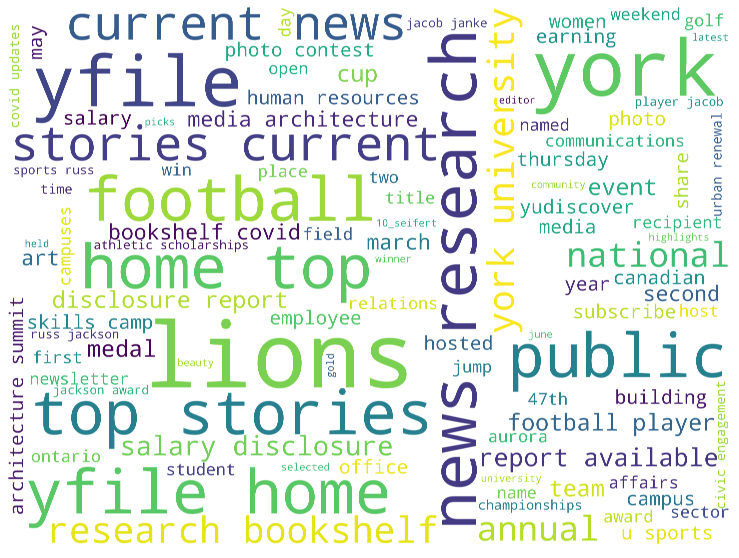

In [37]:
wordcloud = WordCloud(
    width=2000,
    height=1500,
    scale=10,
    max_font_size=250,
    max_words=100,
    background_color="white",
).generate(str(words))
plt.figure(figsize=[35, 10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()